# Chapter 9: Training A Contrastive Language Image Pre-Training (CLIP) Model


This chapter covers

* Compressing a text description into a D-value embedding 
* Converting an image into an embedding also with D values 
* Building and training a CLIP model to match text-image pairs
* Using the trained CLIP model to select an image based on a text prompt
* Using the OpenAI pretrained CLIP to select an image based on text 

In recent years, text-to-image Transformers such as OpenAI's DALL-E 2, Google's Imagen, and
Stability AI's Stable Diffusion, have gained significant attention for their
ability to generate high-quality images based on textual descriptions. These text-to-image models comprise three essential components: (1) a text encoder that compresses text into a latent representation; (2) a method to incorporate text information into the image generation process; and (3) a diffusion mechanism to gradually refine an image to produce realistic output. While we have discussed components (1) and (3) in the early chapters, we'll focus on how to accomplish component (2) in this chapter.  

In 2021, OpenAI released the Contrastive Language-Image Pre-training (CLIP) model (Radford et al, Learning Transferable Visual Models From Natural Language Supervision, https://arxiv.org/abs/2103.00020). This innovative model is designed to understand and interpret images in the context of natural language, a capability that holds immense potential for various applications such as image generation and image classification.

The CLIP model is a multimodal Transformer that bridges the gap between visual and textual
data. It is trained to understand images by associating them with corresponding textual
descriptions. Unlike traditional models that require explicit labeling of images, CLIP leverages a vast dataset of images and their natural language descriptions to learn a more generalizable
representation of visual concepts.

To train the model, a large-scale training dataset of text-image pairs is collected. The text encoder of the model compresses the text description into a D-value text embedding. The image encoder converts the corresponding image into an image embedding also with D values. During training, a batch of N text-image pairs are converted to N text embeddings and N image embeddings. CLIP uses a contrastive learning approach to maximize the similarity between paired embeddings while minimizing the similarity between embeddings from non-matching text-image pairs.

In this chapter, you'll learn to create a CLIP model from scratch and use the 8000 images-caption pairs in the Flickr 8k dataset to train the model. Once the model is trained, you can perform an "image selection" task as follows. You enter a text description, and use the trained model to come up with an image that best matches the text description. The experiment is not exactly "text to image generation," but can be considered "text to image selection." For many text descriptions such as "a dog walks on the beach" or "people eating in the restaurant," the selected images match the text descriptions well. 

OpenAI has made its pretrained CLIP model public. Later in this book, we'll rely mainly on this pretrained model in many text-to-image generation projects. Since OpenAI's CLIP model is trained on a large amount of text-image pairs, the model can provide a more generalizable representation of visual concepts. You'll repeat the experiment of text-to-image generation with the pretrained OpenAI CLIP model. For many common text descriptions, the selected images match the text descriptions well. 

# 1.    Convert Images and Captions to Vectors
You’ll use the Flickr 8k dataset to train CLIP in this chapter. The Flickr 8K dataset is a collection of around 8,000 photographs sourced from the Flickr website, each annotated with five different descriptive captions provided by human annotators. This dataset is specifically designed for developing and evaluating image captioning models. The diverse set of images typically depict people or animals performing various activities in a wide range of settings. The annotations are intended to facilitate the training of machine learning models that can generate descriptive text for images automatically. However, our purpose is to select images from the dataset based on a text prompt. 

In this section, you'll download the dataset, split them into a train and test set, and place them in batches for training later. You'll also visualize some sample images to see what the images in this dataset look like.

The Python program in this chapter is adapted from a great GitHub repository by Moein Shariatnia (https://github.com/moein-shariatnia/OpenAI-CLIP). 

## 1.1 Download and Visualize Flickr 8k Images
You can download the Flickr 8k images and the associated text captions from the Kaggle website (https://www.kaggle.com/datasets/adityajn105/flickr8k). Log in to your Kaggle account, download the zip file, extract the data from the zip file. There is a text file captions.txt and a folder /images/ in the zip file. Place them in the folder /files/ on your computer.  

We'll first extract the captions for these images as follows:

In [1]:
import pandas as pd

# change the file path according to where you saved the file
df=pd.read_csv(r'files/captions.txt',
               delimiter=",")

Make sure you use the delimiter="," argument in the read_csv() method in the pandas library since each row in the file captions.txt is separated to two columns by a comma (",").

You can print out the first 12 observations as follows:

In [2]:
print(df.head(n=12))

                        image  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   
11  1002674143_1b742ab4b8.jpg   

                                              caption  
0   A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building .  
2    A little girl climbing into a wooden playhouse .  
3   A little girl climbing the stairs to her playh...  
4   A little girl in a pink dress going into a woo...  
5          A black dog and a spotted dog are fighting  
6   A black dog and a tri-colored dog playing with...  
7   A black dog and a white dog with brown spots a...  
8   Two dogs of different breeds looking at each o...  
9     Two 

As you can see, each image is given five text descriptions. 

Next, we can visualize ten images with their shortest captions as follows:

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_18972\4037383414.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi["length"]=dfi["caption"].str.len()


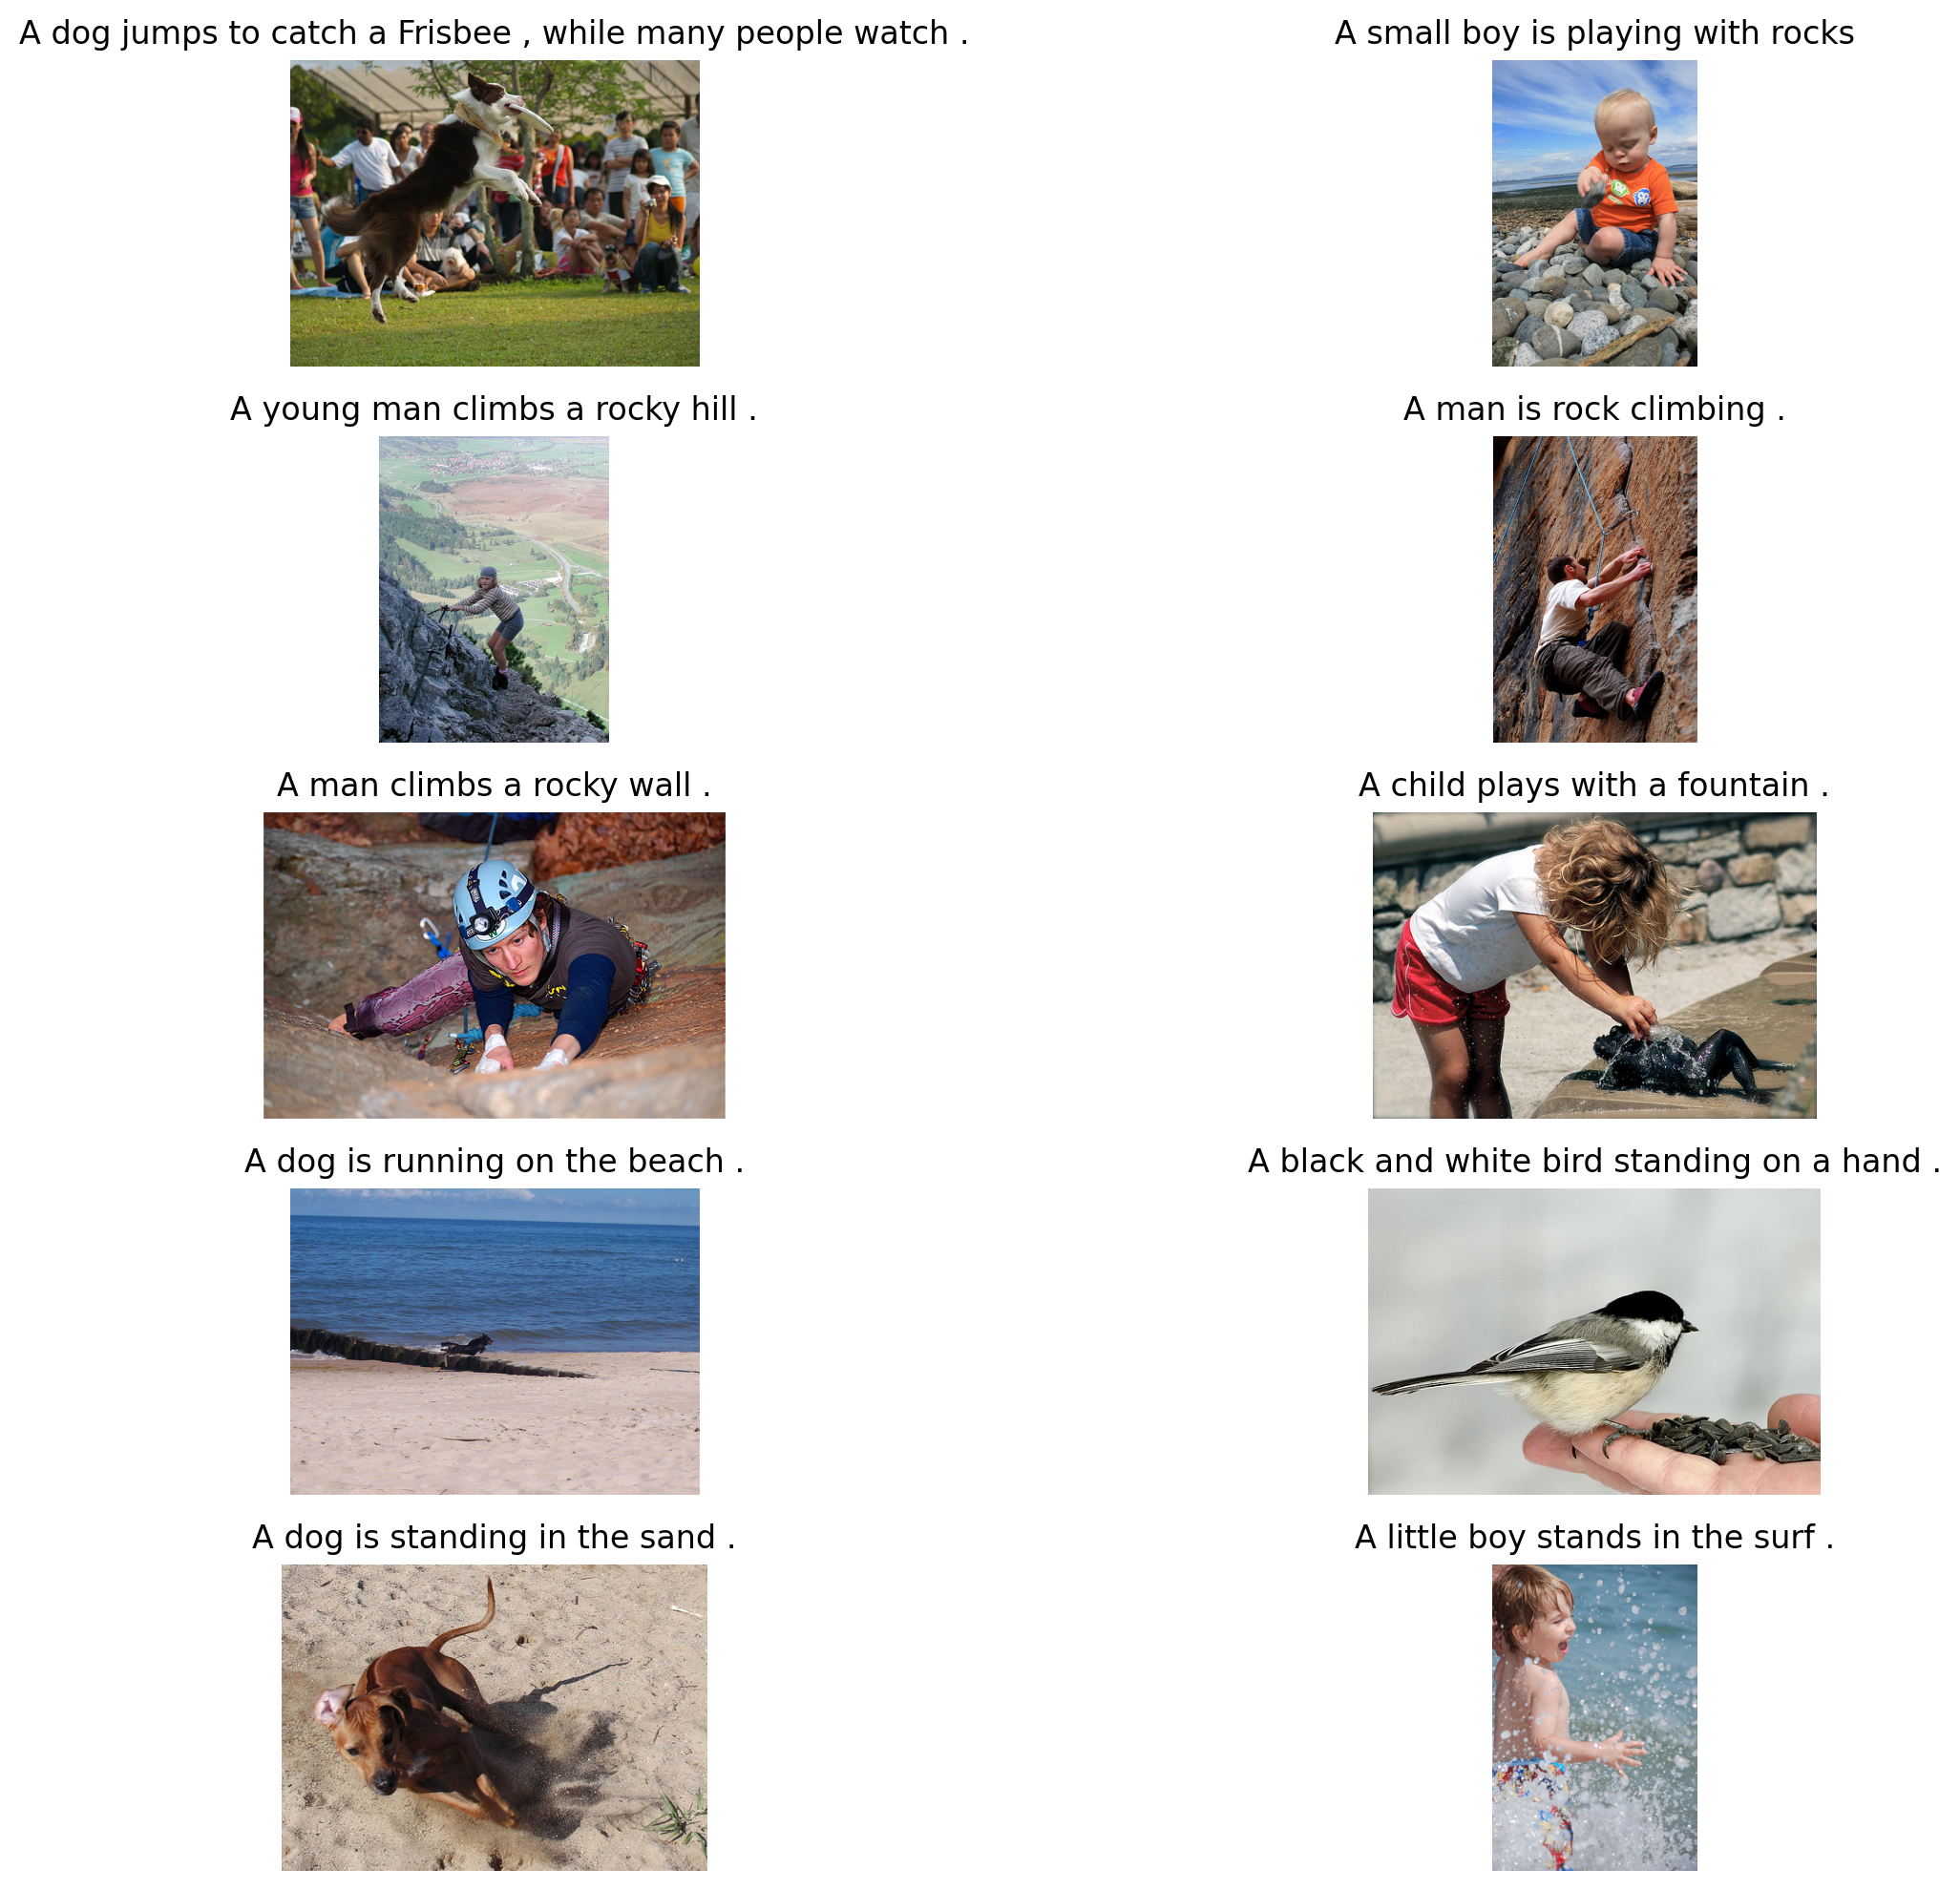

In [3]:
imgfolder=r"files/Images"
import os
with os.scandir(imgfolder) as fb:
    files=[f.name for f in fb]

# select ten images
start=100
imgs=files[start:start+10]
# retrieve the shortest caption for them
dfi=df[df["image"].isin(imgs)]
dfi["length"]=dfi["caption"].str.len()
dfi=dfi.sort_values(['image',"length"])
dfi=dfi.groupby("image").first()

import PIL
from matplotlib import pyplot as plt
plt.figure(dpi=200,figsize=(15,10))
for i in range(10):
    plt.subplot(5,2, i+1)
    img=f"{imgfolder}/{dfi.index[i]}"
    nparray=PIL.Image.open(img)
    plt.imshow(nparray)
    plt.title(f"{dfi.iloc[i]['caption']}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 1.2 Convert Captions to Vectors
The idea behind CLIP is to use deep neural networks to compress text captions into vectors in a latent space. At the same time, we also compress images to vectors of the same length in a latent space. We then train the model so that the text vector matches the image vector for each text-image pair. 

Below, you'll learn to use the trained DistilBert model to encode text descriptions in captions into vector representations. 

We'll split the dataset into train and validation subsets, as follows:

In [4]:
import numpy as np
image_ids = np.arange(0, len(df))
np.random.seed(42)
valid_ids = np.random.choice(
    image_ids, size=int(0.2 * len(df)), replace=False)
train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
train = df[df.index.isin(train_ids)].reset_index(drop=True)
valid = df[df.index.isin(valid_ids)].reset_index(drop=True)

To save space, we'll define various functions and classes for this chapter in a local module CLIPutil.py. Download the file CLIPutil.py from the book's GitHub repository https://github.com/markhliu/txt2img and place it in the folder /utils/ on your computer. Make sure that you place a blank file names $__init__.py$ in the folder /utils/ so that Python treats files in the folder as Python modules. 

In the local module CLIPutil.py, we have defined a CFG() class to store all hyperparameters used in this chapter, as follows:

```python
class CFG:
    image_path = r"files/Images"
    captions_path = r"files"
    batch_size = 32
    head_lr = 1e-3
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200
    pretrained = True 
    trainable = False 
    temperature = 1.0
    size = 224
    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1
```

We'll explain these hyperparameters as we go along.

In the local module CLIPutil.py, we have defined a CLIPDataset() class as follows:

```python
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self,image_filenames,captions,tokenizer,
                 transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True,
            max_length=CFG.max_length)
        self.transforms = transforms
    def __getitem__(self, idx):
        item = {key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()}
        image = cv2.imread(
            f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image']=torch.tensor(image).permute(2,0,1).float()
        item['caption'] = self.captions[idx]
        return item
    def __len__(self):
        return len(self.captions)
```

The CLIPDataset() class uses the DistilBert model to encode captions into a sequence of indexes, with each index representing a token. It also converts the corresponding image into a standard shape of (3, 224, 224): three color channels, with height and width of 244 pixels. 

Below, we apply the CLIPDataset() class on both the train and test sets. We also place them in batches, with a batch size of 32.

In [5]:
from transformers import (DistilBertModel, DistilBertConfig, 
                          DistilBertTokenizer)
from utils.CLIPutil import get_transforms, CLIPDataset, CFG
import torch

tokenizer = DistilBertTokenizer.from_pretrained(
    CFG.text_tokenizer)
transforms = get_transforms()
trainset = CLIPDataset(train["image"].values,
    train["caption"].values,tokenizer=tokenizer,
                       transforms=transforms)
trainloader = torch.utils.data.DataLoader(trainset,
    batch_size=CFG.batch_size,shuffle=True)
valset = CLIPDataset(valid["image"].values,
    valid["caption"].values,tokenizer=tokenizer,
                     transforms=transforms)
valloader = torch.utils.data.DataLoader(valset,
    batch_size=CFG.batch_size,shuffle=False)

We'll use the data in the train and test loaders to train and test the CLIP model later in the chapter. To get a sense of what the training data looks like, we can retrieve the first batch in the train loader as follows:

In [6]:
batch0=next(iter(trainloader))
print(batch0.keys())

dict_keys(['input_ids', 'attention_mask', 'image', 'caption'])


Each batch is a Python dictionary with four key-value pairs. The keys are 'input_ids', 'attention_mask', 'image', and 'caption'. We can print out the first item in the values corresponding to the four keys as follows:

In [7]:
print(batch0['input_ids'][0])
print(batch0['attention_mask'][0])
print(batch0['image'][0].shape)
print(batch0['caption'][0])

tensor([  101,  1037,  2158,  2003,  5362, 12701,  2091,  1037,  4586,  3139,
         2940,  4147,  1037, 13383,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([3, 224, 224])
A man is carefully skiing down a snow covered hill wearing a backpack .


The input_ids for a caption is a sequence of integers. The sequence is added with 0 at the end to make sure that all sequences in the batch have the same length. The 'attention_mask' vector mask out the paddings at the end so the model pays attention to the indexes corresponding to the captions, not to the 0s at the end of the sequence. Each image is now represented by a tensor with a size of (3, 224, 224). The original caption is also included in the dictionary. 

Next, we'll create a CLIP model and use the data to train the model so that it can match captions with the images. 

# 2 Create A CLIP Model
Now that you have the training data ready, you'll learn to create a CLIP model. The CLIP model consists of a text encoder and an image encoder. It compresses an image and the associated captions into a 256-value vector so that we can later to train the model to match the two vectors.  

In the next section, you'll then use the data to train the model to match a caption with an image. You'll then type in any text prompt and us the trained CLIP model to find the closest match to the prompt. 

## 2.1 Create A Text Encoder
Our CLIP model has a text encoder and an image encoder. The text encoder converts sequences of indexes, which represent the tokens in the text descriptions of the images, into a vector in the latent space. The image encoder converts an image into a vector of the same length in the latent space. 

In the local module CLIPutil.py, we define the TextEncoder() class as follows:

```python
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, 
                 pretrained=CFG.pretrained, 
                 trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model=DistilBertModel.from_pretrained(model_name)
        else:
            self.model=DistilBertModel(config=DistilBertConfig())            
        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, 
                attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:,self.target_token_idx,:]   
```

We'll use the pretrained DistilBert model from Hugging Face to reduce the training time. Interested readers can change the hyperparameter pretrained to True to train the DistilBert model from scratch. 

We can count the number of trainable and untrainable parameters in the text encoder defined above, like so:

In [8]:
from utils.CLIPutil import TextEncoder

textencoder=TextEncoder()
num_trainable = sum([p.numel() for p in 
    textencoder.parameters() if p.requires_grad])
print(f"Number of trainable parameters: {num_trainable}")
non_trainable = sum([p.numel() for p in 
    textencoder.parameters() if not p.requires_grad])
print(f"Number of untrainable parameters: {non_trainable}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of trainable parameters: 0
Number of untrainable parameters: 66362880


The DistileBert model has more than 66 million parameters. By turning off the trainable argument, we can speed up the training process. 

Note that the text encoder returns the weight associated with the first token in each sequence in the last hidden layer. As we discussed in the last chapter, the CLS token signals the start of a sequence. It is not associated with any specific part of the text but is used to aggregate information across the entire text description. 

You can apply the text encoder on the first batch of training data as follows:

In [9]:
encoded_text=textencoder(batch0['input_ids'],
                         batch0['attention_mask'])
print(encoded_text.shape)

torch.Size([32, 768])


We feed the input IDs and attention masks in the first batch to the text encoder, the output has a shape of (32, 768). There are 32 captions in the batch, and each caption is converted into a 768-value vector. 

## 2.2 Create An Image Encoder
We'll use the ResNet50 model from the timm library as our image encoder. In the local module CLIPutil.py, we define the ImageEncoder() class as follows:

```python
class ImageEncoder(nn.Module):
    def __init__(self, model_name=CFG.model_name, 
        pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained,
            num_classes=0,global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = trainable
    def forward(self, x):
        return self.model(x)  
```

We'll use the pretrained weights to reduce the training time. To count the number of trainable and untrainable parameters in the image encoder defined above, run the following code cell:

In [10]:
from utils.CLIPutil import ImageEncoder

imageencoder=ImageEncoder()
num_trainable = sum([p.numel() for p in imageencoder.parameters() 
                     if p.requires_grad])
print(f"Number of trainable parameters: {num_trainable}")
non_trainable = sum([p.numel() for p in imageencoder.parameters() 
                     if not p.requires_grad])
print(f"Number of untrainable parameters: {non_trainable}")

Number of trainable parameters: 0
Number of untrainable parameters: 23508032


The ResNet50 model has more than 23 million parameters. By turning off the trainable argument, we can speed up the training process.

You can apply the image encoder on the first batch of training data as follows:

In [11]:
encoded_image=imageencoder(batch0['image'])
print(encoded_image.shape)

torch.Size([32, 2048])


We feed the images in the first batch to the image encoder, the output has a shape of (32, 2048). There are 32 images in the batch, and each image is converted into a 2048-value vector. 

## 2.3	Build A CLIP Model
You may have noticed that each caption is converted to a 768-value vector while each image is converted to a 2048-value vector. To make the dimensions of the text embedding and image embedding the same, we define the following ProjectionHead() class in the local module:

```python
class ProjectionHead(nn.Module):
    def __init__(self,embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, 
                                    projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x  
```

The projection head converts both the text embedding and the image embedding into a 256-value vector so that we can train the CLIP model to match the two vectors. That is, to make the values in the two vectors as close to each other as possible. 

The CLIP model is defined in the local module as follows:

```python
class CLIPModel(nn.Module):
    def __init__(self,temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(
            embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(
            embedding_dim=text_embedding)
        self.temperature = temperature
    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        # Calculating the Loss
        logits = \
        (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
        (images_similarity + 
         texts_similarity) / 2 * self.temperature,
        dim=-1)    
        texts_loss = cross_entropy(logits, targets, 
                                   reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, 
                                    reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 
        return loss.mean()
```

The CLIP model converts text captions and images to 256-value vectors and calculates the similarities between the two vectors. The model adjusts parameters so that similar captions lead to similar images and vice versa. 

Each batch contains 32 images in our case. So both image_embeddings and text_embeddings have a size of (32, 256). The logits in the CLIP model is a matrix with a size of (32, 32), which measures the similarities of the 32 images in the batch. But how do we measure similarities? Similar captions (texts_similarity) or similar image content (images_similarity)? The model use a average of the two: similarities of images in the batch is the simple average of images_similarity and texts_similarity. The model then compares the average of the two to the logits from the model.   

# 3.	Train and Use the CLIP Model
Now that we have both the training data and the CLIP model, we'll train the model to match images with captions. After that, we'll use the trained model to select an image based on a given text prompt.

## 3.1 Train the CLIP Model
We first import the CLIPModel from the local module and instantiate the class to create our CLIP model:

In [12]:
from utils.CLIPutil import CLIPModel, CFG

model = CLIPModel().to(CFG.device)
num_trainable = sum([p.numel() for p in model.parameters() 
                     if p.requires_grad])
print(f"Number of trainable parameters: {num_trainable}")
non_trainable = sum([p.numel() for p in model.parameters() 
                     if not p.requires_grad])
print(f"Number of untrainable parameters: {non_trainable}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of trainable parameters: 854016
Number of untrainable parameters: 89870912


Since we use trained weights from the DistilBert model for text encoding and the ResNet50 model for image encoding, our model has only 854,016 trainable parameters. 

Below, we define the optimizer and the learning rate scheduler as follows:

In [13]:
import itertools

params = [
    {"params": itertools.chain(
        model.image_projection.parameters(), 
        model.text_projection.parameters()
    ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, 
    factor=CFG.factor
)

We'll train the model for ten epochs. We test the performance of the model after each epoch and save the best model based on model performance on the test set.

In [14]:
scaler = torch.cuda.amp.GradScaler()  
best_loss = float('inf')
from tqdm import tqdm
for epoch in range(10):
    print(f"Epoch: {epoch + 1}")
    model.train()
    losses = []
    tqdm_object = tqdm(trainloader, total=len(trainloader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in
                 batch.items() if k != "caption"}
        with torch.cuda.amp.autocast():
            loss = model(batch)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  
        losses.append(loss.item())
        avgloss=sum(losses)/len(losses)
        tqdm_object.set_description(f"loss is {avgloss:.5f}")
    model.eval()
    losses = []
    with torch.no_grad():
        tqdm_object = tqdm(valloader, total=len(valloader))
        for batch in tqdm_object:
            batch = {k: v.to(CFG.device) for k, v in 
                     batch.items() if k != "caption"}
            loss = model(batch)
            losses.append(loss.item())
            avgloss=sum(losses)/len(losses)
            tqdm_object.set_description(
                f"valid_loss={avgloss:.2f}")
    if avgloss < best_loss:
        best_loss = avgloss
        torch.save(model.state_dict(), "files/best.pth")
        print("Saved Best Model!")
    lr_scheduler.step(avgloss)

```
Epoch: 1
loss is 3.01018: 100%|██████████| 1012/1012 [02:47<00:00,  6.06it/s]
100%|██████████| 253/253 [00:45<00:00,  5.58it/s, valid_loss=1.98]
Saved Best Model!
Epoch: 2
loss is 1.60353: 100%|██████████| 1012/1012 [02:50<00:00,  5.92it/s]
100%|██████████| 253/253 [00:45<00:00,  5.57it/s, valid_loss=1.61]
Saved Best Model!
Epoch: 3
loss is 1.27415: 100%|██████████| 1012/1012 [02:51<00:00,  5.92it/s]
100%|██████████| 253/253 [00:45<00:00,  5.59it/s, valid_loss=1.54]
Saved Best Model!
Epoch: 4
loss is 1.11666: 100%|██████████| 1012/1012 [02:50<00:00,  5.92it/s]
100%|██████████| 253/253 [00:45<00:00,  5.61it/s, valid_loss=1.46]
Saved Best Model!
Epoch: 5
loss is 0.99789: 100%|██████████| 1012/1012 [02:54<00:00,  5.81it/s]
100%|██████████| 253/253 [00:45<00:00,  5.53it/s, valid_loss=1.41]
Saved Best Model!
Epoch: 6
loss is 0.89526: 100%|██████████| 1012/1012 [02:50<00:00,  5.92it/s]
100%|██████████| 253/253 [00:45<00:00,  5.55it/s, valid_loss=1.37]
Saved Best Model!
Epoch: 7
loss is 0.82653: 100%|██████████| 1012/1012 [02:50<00:00,  5.95it/s]
100%|██████████| 253/253 [00:45<00:00,  5.59it/s, valid_loss=1.32]
Saved Best Model!
Epoch: 8
loss is 0.74896: 100%|██████████| 1012/1012 [02:50<00:00,  5.94it/s]
100%|██████████| 253/253 [00:45<00:00,  5.54it/s, valid_loss=1.28]
Saved Best Model!
Epoch: 9
loss is 0.69506: 100%|██████████| 1012/1012 [02:51<00:00,  5.90it/s]
100%|██████████| 253/253 [00:45<00:00,  5.52it/s, valid_loss=1.3] 
Epoch: 10
loss is 0.63569: 100%|██████████| 1012/1012 [02:51<00:00,  5.91it/s]
100%|██████████| 253/253 [00:45<00:00,  5.57it/s, valid_loss=1.28]
```

Note that we used PyTorch’s automatic mixed precision package torch.cuda.amp to speed up training. The best model is achieved after 8 epochs of training. 

## 3.2	Use the Trained CLIP Model to Select Images
First, we load the best model during training as follows:

In [15]:
sd=torch.load(r"files/best.pth")
model.load_state_dict(sd)
model.eval()

We first obtain the image embeddings of all images in the validation set and use them as potential candidates for a match for any text prompt. 

In [16]:
image_embeds = []
with torch.no_grad():
    for batch in tqdm(valloader):
        image_features = model.image_encoder(
            batch["image"].to(CFG.device))
        image_embeds.append(
            model.image_projection(image_features))
image_embeddings = torch.cat(image_embeds)        

100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:48<00:00,  5.19it/s]


We save the image embeddings on the computer so that we don't need to create image embeddings again later.

In [17]:
import pickle

with open("files/image_embeds.p","wb") as f:
    pickle.dump(image_embeddings, f)

Next, we define a match() function to find a matching image from the validation set as follows: 

In [18]:
def match(prompt):
    encoded = tokenizer([prompt])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    dot_similarity = text_embeddings @ image_embeddings.T
    values, idx = torch.topk(dot_similarity.squeeze(0), 1)
    img=valid['image'].values[idx.item()]
    caption=valid['caption'].values[idx.item()]
    return img, caption
print(match("a horse walks on the beach"))

('2591603141_33d6397e0a.jpg', 'A fluffy dog walks along the sandy beach .')


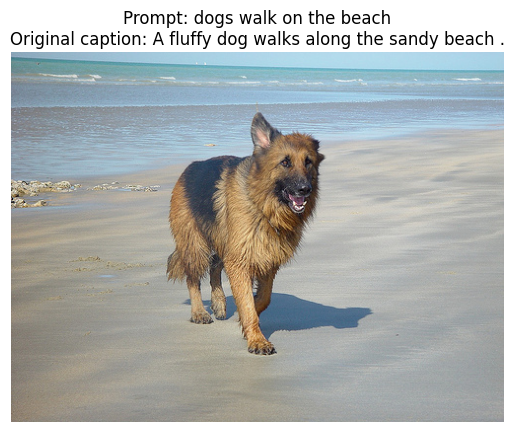

In [19]:
from PIL import Image
from matplotlib import pyplot as plt
prompt="dogs walk on the beach"
file,cap=match(prompt)
plt.imshow(Image.open(
    rf"files/Images/{file}"))
plt.title(f"Prompt: {prompt}\nOriginal caption: {cap}")
plt.axis("off")
plt.show()

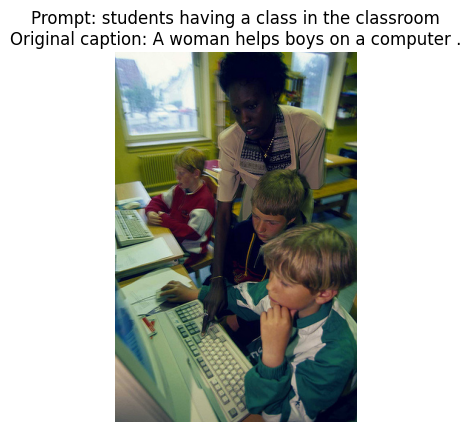

In [20]:
prompt="students having a class in the classroom"
file,cap=match(prompt)
plt.imshow(Image.open(
    rf"files/Images/{file}"))
plt.title(f"Prompt: {prompt}\nOriginal caption: {cap}")
plt.axis("off")
plt.show()

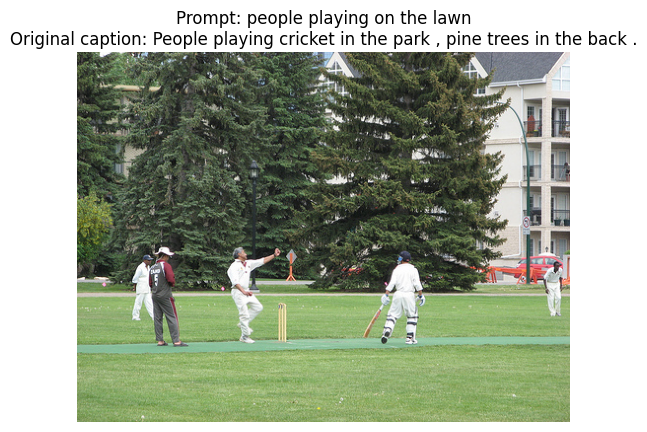

In [21]:
prompt="people playing on the lawn"
file,cap=match(prompt)
plt.imshow(Image.open(
    rf"files/Images/{file}"))
plt.title(f"Prompt: {prompt}\nOriginal caption: {cap}")
plt.axis("off")
plt.show()

# 4. Use OpenAI Pretrained CLIP Model to Predict Image from Text
OpenAI has made its pretrained CLIP model public. Later in this book, we'll rely mainly on that model since it's trained on more text-image pairs. Therefore, the model can provide a more generalizable representation of visual concepts.

In this section, we'll enter a text prompt and use the CLIP model to search for an image from the Flickr 8k database to match the text description. It's not exactly text to image generation, but there is a flavor of that. 

## 4.1 Generate embeddings for all images in Flickr 8k
We'll first use the OpenAI pretrained CLIP model to encode all images in Flickr 8k. To do that, we'll first clone the OpenAI GitHut repository and place it in the local folder so that we can use the OpenAI CLIP model. Make sure you have the git app installed on your computer. If not, follow the instructions here https://git-scm.com/book/en/v2/Getting-Started-Installing-Git to install git based on your operating system.

Once you have git installed on your computer, run the following line of code in a cell in Jupyter Notebook:

In [22]:
!git clone https://github.com/openai/CLIP

Now, all the files related to the OpenAI CLIP model is placed in the CLIP folder on your computer. We'll use the sys library to give Python access to the folder as follows:

In [23]:
import sys

sys.path.append("./CLIP")

Next, we encode all images in the Flickr 8k dataset:

In [24]:
import os

# get a list of all Flickr 8k images
folder=r"files/Images"
with os.scandir(folder) as files:
    names=[file.name for file in files]

# use the pretained OpenAI CLIP model
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

images=[]
for i in names:
    images.append(preprocess(Image.open(f"{folder}/{i}"
                            )).unsqueeze(0).to(device))
  
image=torch.cat(images)    
print(image.shape)  

#obtain image embeddings
with torch.no_grad():
    image_features = model.encode_image(image)

import pickle

# save the embeddings for later use
with open("files/imgfeas.p","wb") as fb:
    pickle.dump(image_features,fb)

There are 8091 images in Flickr 8k. The list image contains all the images, in the shape of (3, 224, 224).

The tensor image_features are saved on your computer for later use.

## 4.2 Find a match from Flickr 8k based on a text prompt
Next, we'll define a find_match() function to find and plot five images that best match a text prompt:

In [25]:
import PIL
from matplotlib import pyplot as plt

def find_match(prompt): 
    print(f"prompt is {prompt}")
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
    simu=text_features@image_features.T
    values, indices = torch.topk(simu[0], 5)
    plots=[]
    for i in indices:
        plots.append(names[i])
    plt.figure(dpi=200,figsize=(10,2))
    for i in range(5):
        plt.subplot(1,5, i+1)
        img=f"{folder}/{plots[i]}"
        nparray=PIL.Image.open(img)
        plt.imshow(nparray)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Now we can load the image embeddings and call the find_match() function to find matches. 

prompt is people shopping on the street


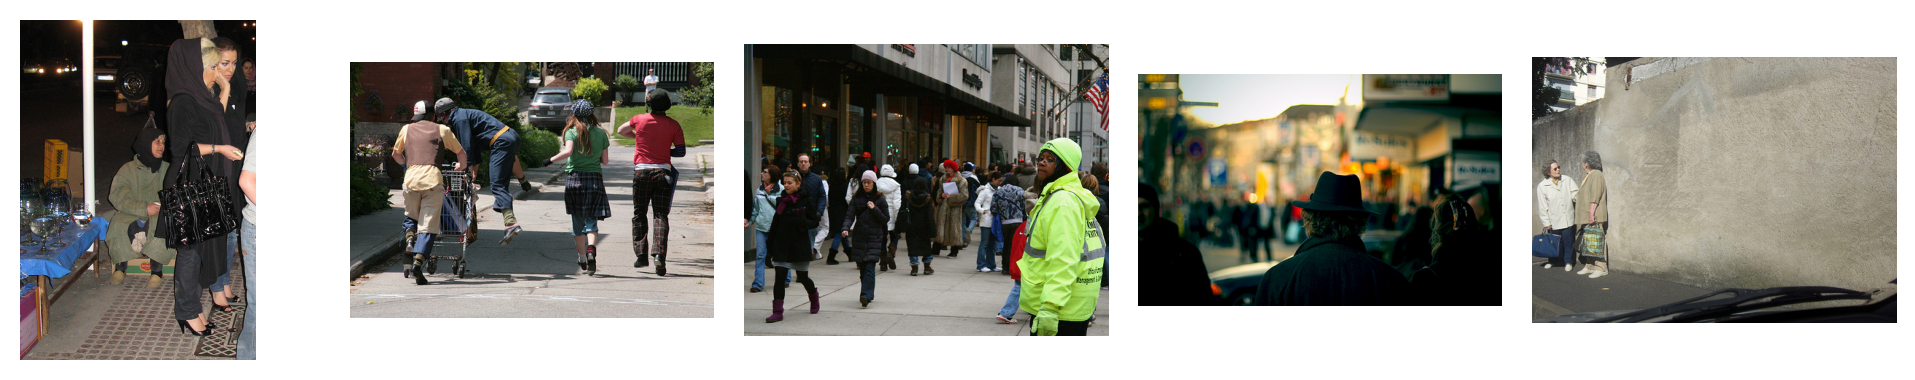

In [26]:
import pickle

with open("files/imgfeas.p","rb") as fb:
    image_features=pickle.load(fb)

find_match("people shopping on the street") 

The find_match() function display five image that match the text prompt, with the left image the most likely match. 

We entered the prompt "people shopping on the street." The first image does look like a group of people shopping on the street. Note that our dataset is small. If we apply the same method to a large dataset, say, with millions of images with diverse settings, the match will be much closer to the text description.

Next, we use "a dog plays on the beach" as the prompt:

prompt is a dog plays on the beach


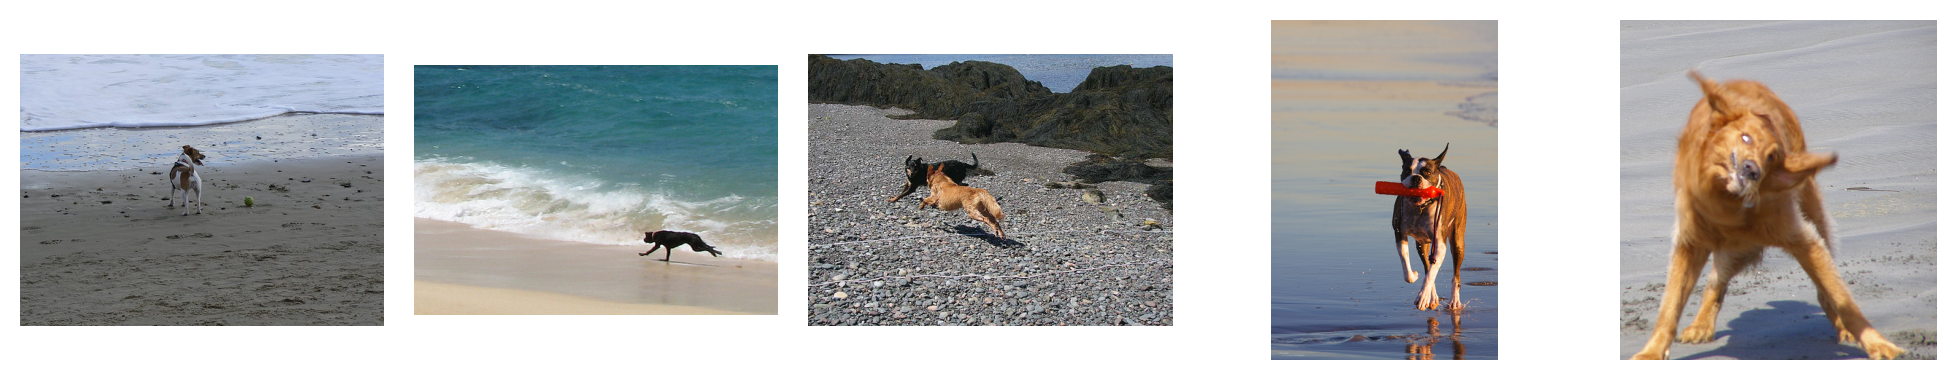

In [27]:
find_match("a dog plays on the beach") 

We find great matches for this prompt!

Let's try one more:

prompt is people eating at the restaurant


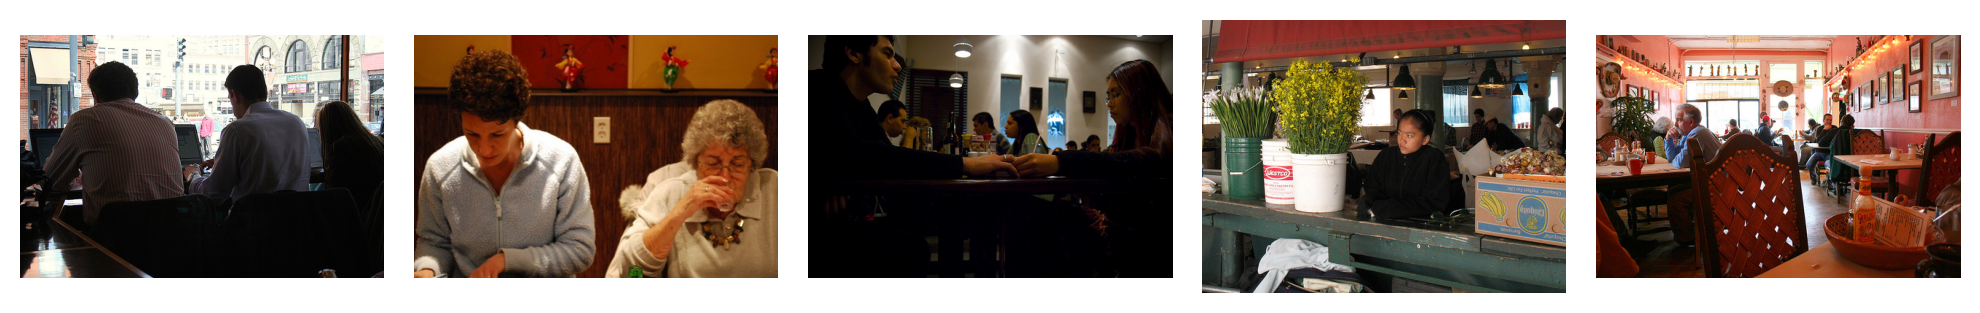

In [28]:
find_match("people eating at the restaurant") 

The matches for this prompt seem to show people gathering indoors for some activities, likely eating. 